## CONNECTION TO DRIVE AND SET UP

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/DATASET/CatsDogs.zip > /dev/null

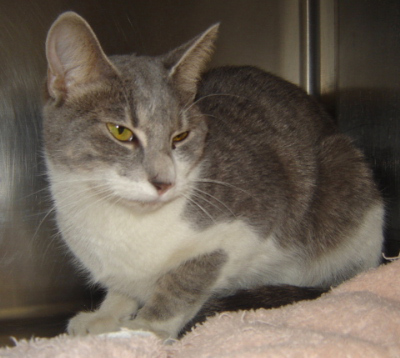

In [ ]:
prova_path="CatsDogs/Cats/4352.jpg"
import tensorflow as tf
img = tf.keras.preprocessing.image.load_img(prova_path)
img

In [ ]:
import numpy as np
import os
from os import listdir
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
import seaborn as sns
import math
import time
import gc

import tensorflow as tf

from keras.models import Sequential
#from keras.layers import Conv2D
#from keras.layers import MaxPooling2D
#from keras.layers import Dense
#from keras.layers import Flatten
#from keras.layers import Dropout
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Rescaling, RandomFlip, RandomZoom, RandomContrast,RandomHeight, RandomWidth

from tensorflow.keras.optimizers import SGD
from keras.layers import BatchNormalization
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# PREPROCESSING

The next cell was used to find corrupted images in the dataset.

Then this script eliminate automaticaly the corrupted images from the folder.

In [ ]:
classes=["Cats","Dogs"]
for label in classes:
    for filename in os.listdir("CatsDogs/"+label):
        path="CatsDogs/"+label+"/" + filename
        #print(path)
        bytess=tf.io.read_file(path)
        try:
            tf.io.decode_image(
            bytess,
            dtype=tf.dtypes.uint8,
            expand_animations=True
            )
        except Exception:
            print(path)
            os.remove(path)

CatsDogs/Cats/666.jpg
CatsDogs/Cats/10404.jpg
CatsDogs/Cats/4351.jpg
CatsDogs/Dogs/2317.jpg
CatsDogs/Dogs/2494.jpg
CatsDogs/Dogs/9500.jpg
CatsDogs/Dogs/11912.jpg
CatsDogs/Dogs/11702.jpg
CatsDogs/Dogs/11233.jpg


In [ ]:
cats_dir="CatsDogs/Cats"
dogs_dir="CatsDogs/Dogs"
batch_size=64

cat_ds = tf.keras.utils.image_dataset_from_directory(
  cats_dir,
  seed=123,
  image_size=(80, 80),
  labels=None,
  batch_size=batch_size)

dog_ds = tf.keras.utils.image_dataset_from_directory(
  dogs_dir,
  seed=123,
  image_size=(80, 80),
  labels=None,
  batch_size=batch_size)

Found 12497 files belonging to 1 classes.
Found 12494 files belonging to 1 classes.


In [ ]:
cat_images = np.concatenate(list(cat_ds.map(lambda x:x)))

dog_images = np.concatenate(list(dog_ds.map(lambda x:x)))

gc.collect()

170

In [ ]:
cat_labels=[0]*12497  #number of cat images
cat_labels = np.array(cat_labels)

dog_labels=[1]*12494  #number of dog images
dog_labels = np.array(dog_labels)

In [ ]:
X = np.concatenate((cat_images, dog_images), axis=0)
y = np.concatenate((cat_labels, dog_labels), axis=0)

As we can see in the next cell, y contains before all the cats labels and then all the dogs labels. What We need to do is shuffling IN THE SAME WAY both the X and the y array. so that the i-th element in X is still associated with its label.

In [ ]:
print(y[:10],y[-10:])

[0 0 0 0 0 0 0 0 0 0] [1 1 1 1 1 1 1 1 1 1]


In [ ]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [ ]:
X,y=unison_shuffled_copies(X,y)

Let's make a little check that:
1. the vectors have been shuffled
2. The dogs images are associated with dogs labels (the same for cats).

In [ ]:
y[:5]

array([0, 0, 0, 1, 0])

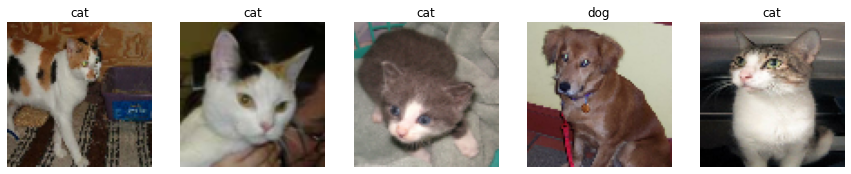

In [ ]:
def print_label(x):
  if x==1: 
    label="dog" 
  else: 
    label="cat"
  return label

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))

for i in range(5):
    ax[i].imshow(X[i].astype(np.uint8))
    ax[i].set_title(print_label(y[i]))
    ax[i].axis('off')

DATA SPLIT

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)
X_train,X_valid,y_train,y_valid=train_test_split(X_train,y_train,train_size=0.9,random_state=0)

gc.collect()

2058

In [ ]:
print(X_train.shape,X_test.shape,X_valid.shape)

(17992, 80, 80, 3) (4999, 80, 80, 3) (2000, 80, 80, 3)


# UTILITY FUNCTIONS

In [ ]:
def cross_validation_function(X,y,ep,type):
  tf.get_logger().setLevel('ERROR')
  skf = StratifiedKFold(n_splits=5)
  loss= []
  acc= []
  iteration=1
  for train_index, test_index in skf.split(X,y):
      if type=="oneConv_model":
        model=oneConv_model()
      elif type=="dropout_model":
        model=dropout_model()
      elif type=="deep_model":
        model=deep_model()
      elif type=="augm_model":
        model=augm_model()
      elif type=="not_augm_model":
        model=not_augm_model()
        
      print("********************ITERATION ",iteration, "***********************")
      #model7=new_augm_model()
      history = model.fit(X[train_index], y[train_index],
                batch_size=batch_size,
                verbose=1,
                epochs=ep)
      
      scores = model.evaluate(X[test_index], y[test_index], verbose=0)
      #print("ACCURACY ON THE TEST FOLD: ",scores[1])
      acc.append(scores[1])

      predictions=model.predict(X[test_index])
      for i in range(0,len(predictions)): predictions[i]=np.round(predictions[i])

      print("ZERO ONE LOSS AT ITERATION ",iteration, " : ", zero_one_loss(y[test_index], predictions, normalize=False))
      loss.append(zero_one_loss(y[test_index], predictions, normalize=False))

      iteration=iteration+1
      gc.collect()

  return acc, loss

In [ ]:
def plot_loss_acc(history):

    figure(figsize=(8, 8), dpi=80)

    plt.figure(1)

    plt.subplot(211)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [ ]:
def print_acc_loss(acc,loss):
  print("The average accuracy is: ",(round(sum(acc)/5, 4))*100,"%")
  print("The average loss is: ",np.round(sum(loss)/5))

# 1ST MODEL

This is a very simple neural network with a single convlutional layer.

In [ ]:
def oneConv_model():
    model = Sequential()
        
    model.add(Rescaling(scale=1./255. , input_shape=(80, 80, 3)))
    model.add(Conv2D(32, 3, activation='relu')) 
    model.add(MaxPooling2D(2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
              metrics=['acc'])
    return model

## EXPERIMENT 1: Training with train, test, val split

In [ ]:
model1=oneConv_model()
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 80, 80, 3)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 78, 78, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 39, 39, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 48672)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               6230144   
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                      

In [ ]:
batch_size=64
n_epochs=20

startTime = time.time()
# fit model
history1 = model1.fit(X_train, 
                      y_train,
                      epochs=n_epochs, 
                      validation_data=(X_valid, y_valid),
                      batch_size=batch_size,
                      verbose=1)
print(time.time()-startTime)

Epoch 1/20
282/282 [==============================] - 4s 13ms/step - loss: 0.7456 - acc: 0.5783 - val_loss: 0.6313 - val_acc: 0.6545
Epoch 2/20
282/282 [==============================] - 3s 12ms/step - loss: 0.6156 - acc: 0.6637 - val_loss: 0.5913 - val_acc: 0.6950
Epoch 3/20
282/282 [==============================] - 3s 12ms/step - loss: 0.5762 - acc: 0.6996 - val_loss: 0.5724 - val_acc: 0.7050
Epoch 4/20
282/282 [==============================] - 3s 12ms/step - loss: 0.5517 - acc: 0.7258 - val_loss: 0.5563 - val_acc: 0.7145
Epoch 5/20
282/282 [==============================] - 3s 12ms/step - loss: 0.5288 - acc: 0.7422 - val_loss: 0.5653 - val_acc: 0.7085
Epoch 6/20
282/282 [==============================] - 3s 11ms/step - loss: 0.5119 - acc: 0.7566 - val_loss: 0.5509 - val_acc: 0.7255
Epoch 7/20
282/282 [==============================] - 3s 12ms/step - loss: 0.4953 - acc: 0.7661 - val_loss: 0.5252 - val_acc: 0.7485
Epoch 8/20
282/282 [==============================] - 3s 11ms/step - 

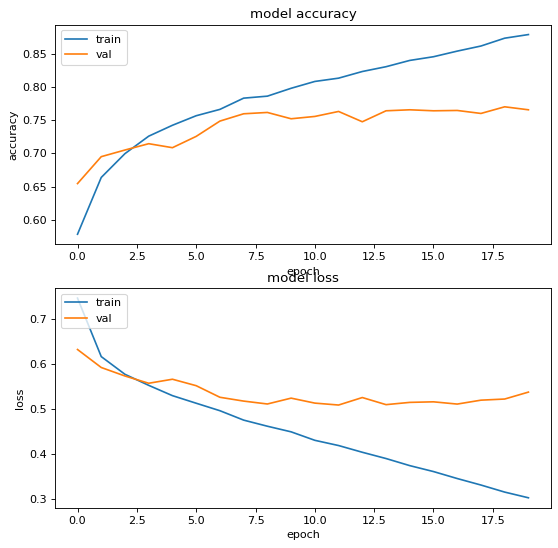

In [ ]:
plot_loss_acc(history1)

ACCURACY ON THE TEST SET:

In [ ]:
gc.collect()

2560

In [ ]:
test_accuracy=model1.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.7531506419181824


In [ ]:
y_pred=model1.predict(X_test)
for i in range(0,len(y_pred)): y_pred[i]=np.round(y_pred[i])

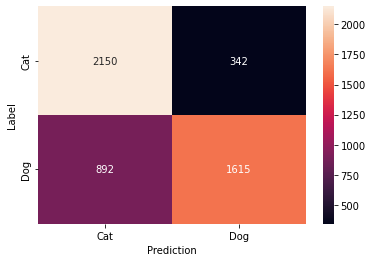

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
labels = ['Cat','Dog']
sns.heatmap(conf_mat,
            xticklabels=labels,
            yticklabels=labels,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## EXPERIMENT 2: Cross validation

In [ ]:
gc.collect()

3877

In [ ]:
acc,loss=cross_validation_function(X,y,20,"oneConv_model")

********************ITERATION  1 ***********************
Epoch 1/20
313/313 [==============================] - 4s 11ms/step - loss: 0.6281 - acc: 0.6617
Epoch 2/20
313/313 [==============================] - 3s 11ms/step - loss: 0.5132 - acc: 0.7549
Epoch 3/20
313/313 [==============================] - 3s 11ms/step - loss: 0.4724 - acc: 0.7790
Epoch 4/20
313/313 [==============================] - 3s 11ms/step - loss: 0.4392 - acc: 0.7990
Epoch 5/20
313/313 [==============================] - 3s 11ms/step - loss: 0.4045 - acc: 0.8194
Epoch 6/20
313/313 [==============================] - 3s 11ms/step - loss: 0.3789 - acc: 0.8339
Epoch 7/20
313/313 [==============================] - 3s 11ms/step - loss: 0.3460 - acc: 0.8517
Epoch 8/20
313/313 [==============================] - 3s 11ms/step - loss: 0.3188 - acc: 0.8622
Epoch 9/20
313/313 [==============================] - 3s 11ms/step - loss: 0.2849 - acc: 0.8825
Epoch 10/20
313/313 [==============================] - 3s 11ms/step - loss: 0.2

In [ ]:
print_acc_loss(acc,loss)

The average accuracy is:  76.41 %
The average loss is:  1179.0


As we can see from both the experiment, bot the models generated with the function "oneConv_model" are OVERFITTING.

# 2ND MODEL





Let's add to the previous model some dropout.

In [ ]:
def dropout_model():
    model = Sequential()
    
    model.add(Rescaling(scale=1./255. , input_shape=(80, 80, 3)))
    model.add(Conv2D(32, 3, activation='relu')) 
    model.add(MaxPooling2D(2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.6))
    #model.add(Dense(1, activation='sigmoid'))
    model.add(Dense(1, activation=tf.nn.sigmoid))
    # compile model
    model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adamax(lr=0.001),
              metrics=['acc'])
    return model

## EXPERIMENT 1: Training with train, test, val split

In [ ]:
model2=dropout_model()
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 80, 80, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 78, 78, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 48672)             0         
                                                                 
 dense (Dense)               (None, 128)               6230144   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


In [ ]:
batch_size=64
n_epochs=20

startTime = time.time()
# fit model
history2 = model2.fit(X_train, 
                      y_train,
                      epochs=n_epochs, 
                      validation_data=(X_valid, y_valid),
                      batch_size=batch_size,
                      verbose=1)
print(time.time()-startTime)

Epoch 1/20
282/282 [==============================] - 17s 17ms/step - loss: 0.7023 - acc: 0.5985 - val_loss: 0.6072 - val_acc: 0.6870
Epoch 2/20
282/282 [==============================] - 5s 17ms/step - loss: 0.6011 - acc: 0.6766 - val_loss: 0.5697 - val_acc: 0.7200
Epoch 3/20
282/282 [==============================] - 4s 15ms/step - loss: 0.5721 - acc: 0.7061 - val_loss: 0.5762 - val_acc: 0.6880
Epoch 4/20
282/282 [==============================] - 3s 12ms/step - loss: 0.5430 - acc: 0.7330 - val_loss: 0.5301 - val_acc: 0.7420
Epoch 5/20
282/282 [==============================] - 3s 12ms/step - loss: 0.5186 - acc: 0.7502 - val_loss: 0.5171 - val_acc: 0.7450
Epoch 6/20
282/282 [==============================] - 3s 12ms/step - loss: 0.4955 - acc: 0.7646 - val_loss: 0.5100 - val_acc: 0.7520
Epoch 7/20
282/282 [==============================] - 3s 12ms/step - loss: 0.4748 - acc: 0.7776 - val_loss: 0.5039 - val_acc: 0.7530
Epoch 8/20
282/282 [==============================] - 3s 12ms/step -

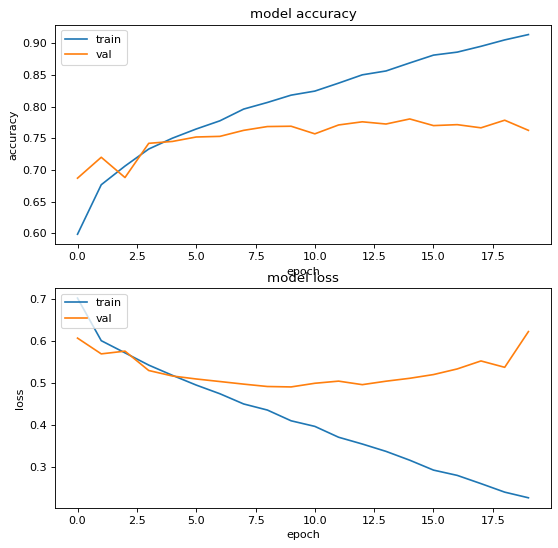

In [ ]:
plot_loss_acc(history2)

Overfitting also here.

ACCURACY ON TEST SET

In [ ]:
test_accuracy=model2.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.7511502504348755


In [ ]:
y_pred=model2.predict(X_test)
for i in range(0,len(y_pred)): y_pred[i]=np.round(y_pred[i])

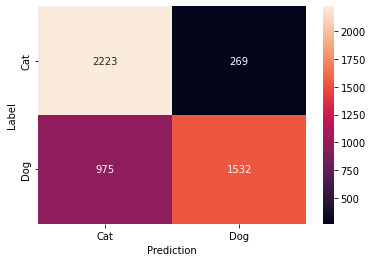

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
labels = ['Cat','Dog']
sns.heatmap(conf_mat,
            xticklabels=labels,
            yticklabels=labels,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## EXPERIMENT 2: Cross Validation

In [ ]:
acc,loss=cross_validation_function(X,y,20,"dropout_model")

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


********************ITERATION  1 ***********************
Epoch 1/20
313/313 [==============================] - 4s 11ms/step - loss: 0.7101 - acc: 0.6073
Epoch 2/20
313/313 [==============================] - 3s 11ms/step - loss: 0.5888 - acc: 0.6973
Epoch 3/20
313/313 [==============================] - 3s 11ms/step - loss: 0.5589 - acc: 0.7210
Epoch 4/20
313/313 [==============================] - 3s 10ms/step - loss: 0.5325 - acc: 0.7376
Epoch 5/20
313/313 [==============================] - 3s 10ms/step - loss: 0.5074 - acc: 0.7580
Epoch 6/20
313/313 [==============================] - 3s 11ms/step - loss: 0.4878 - acc: 0.7713
Epoch 7/20
313/313 [==============================] - 3s 10ms/step - loss: 0.4666 - acc: 0.7855
Epoch 8/20
313/313 [==============================] - 3s 11ms/step - loss: 0.4441 - acc: 0.7960
Epoch 9/20
313/313 [==============================] - 3s 11ms/step - loss: 0.4230 - acc: 0.8079
Epoch 10/20
313/313 [==============================] - 3s 11ms/step - loss: 0.4

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


********************ITERATION  2 ***********************
Epoch 1/20
313/313 [==============================] - 4s 11ms/step - loss: 0.7614 - acc: 0.5624
Epoch 2/20
313/313 [==============================] - 3s 11ms/step - loss: 0.6457 - acc: 0.6174
Epoch 3/20
313/313 [==============================] - 3s 11ms/step - loss: 0.6219 - acc: 0.6535
Epoch 4/20
313/313 [==============================] - 3s 11ms/step - loss: 0.5999 - acc: 0.6768
Epoch 5/20
313/313 [==============================] - 4s 12ms/step - loss: 0.5739 - acc: 0.7023
Epoch 6/20
313/313 [==============================] - 3s 11ms/step - loss: 0.5533 - acc: 0.7201
Epoch 7/20
313/313 [==============================] - 3s 11ms/step - loss: 0.5365 - acc: 0.7339
Epoch 8/20
313/313 [==============================] - 3s 11ms/step - loss: 0.5155 - acc: 0.7480
Epoch 9/20
313/313 [==============================] - 3s 11ms/step - loss: 0.4983 - acc: 0.7644
Epoch 10/20
313/313 [==============================] - 3s 11ms/step - loss: 0.4

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


********************ITERATION  3 ***********************
Epoch 1/20
313/313 [==============================] - 4s 11ms/step - loss: 0.7046 - acc: 0.6039
Epoch 2/20
313/313 [==============================] - 3s 11ms/step - loss: 0.6040 - acc: 0.6763
Epoch 3/20
313/313 [==============================] - 3s 11ms/step - loss: 0.5719 - acc: 0.7063
Epoch 4/20
313/313 [==============================] - 3s 11ms/step - loss: 0.5363 - acc: 0.7363
Epoch 5/20
313/313 [==============================] - 3s 11ms/step - loss: 0.5121 - acc: 0.7552
Epoch 6/20
313/313 [==============================] - 3s 11ms/step - loss: 0.4919 - acc: 0.7658
Epoch 7/20
313/313 [==============================] - 3s 11ms/step - loss: 0.4708 - acc: 0.7832
Epoch 8/20
313/313 [==============================] - 3s 11ms/step - loss: 0.4497 - acc: 0.7957
Epoch 9/20
313/313 [==============================] - 3s 11ms/step - loss: 0.4288 - acc: 0.8052
Epoch 10/20
313/313 [==============================] - 3s 11ms/step - loss: 0.4

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


********************ITERATION  4 ***********************
Epoch 1/20
313/313 [==============================] - 4s 11ms/step - loss: 0.7169 - acc: 0.5582
Epoch 2/20
313/313 [==============================] - 3s 11ms/step - loss: 0.6301 - acc: 0.6393
Epoch 3/20
313/313 [==============================] - 3s 11ms/step - loss: 0.5975 - acc: 0.6799
Epoch 4/20
313/313 [==============================] - 3s 11ms/step - loss: 0.5722 - acc: 0.7077
Epoch 5/20
313/313 [==============================] - 3s 11ms/step - loss: 0.5533 - acc: 0.7236
Epoch 6/20
313/313 [==============================] - 3s 11ms/step - loss: 0.5308 - acc: 0.7405
Epoch 7/20
313/313 [==============================] - 3s 11ms/step - loss: 0.5145 - acc: 0.7520
Epoch 8/20
313/313 [==============================] - 3s 11ms/step - loss: 0.5005 - acc: 0.7630
Epoch 9/20
313/313 [==============================] - 3s 11ms/step - loss: 0.4796 - acc: 0.7755
Epoch 10/20
313/313 [==============================] - 3s 11ms/step - loss: 0.4

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


********************ITERATION  5 ***********************
Epoch 1/20
313/313 [==============================] - 4s 11ms/step - loss: 0.7008 - acc: 0.5834
Epoch 2/20
313/313 [==============================] - 3s 10ms/step - loss: 0.6117 - acc: 0.6672
Epoch 3/20
313/313 [==============================] - 3s 11ms/step - loss: 0.5744 - acc: 0.7035
Epoch 4/20
313/313 [==============================] - 3s 11ms/step - loss: 0.5407 - acc: 0.7319
Epoch 5/20
313/313 [==============================] - 3s 11ms/step - loss: 0.5106 - acc: 0.7591
Epoch 6/20
313/313 [==============================] - 3s 11ms/step - loss: 0.4871 - acc: 0.7718
Epoch 7/20
313/313 [==============================] - 3s 11ms/step - loss: 0.4646 - acc: 0.7870
Epoch 8/20
313/313 [==============================] - 3s 11ms/step - loss: 0.4433 - acc: 0.7984
Epoch 9/20
313/313 [==============================] - 3s 11ms/step - loss: 0.4197 - acc: 0.8095
Epoch 10/20
313/313 [==============================] - 3s 11ms/step - loss: 0.3

In [ ]:
print_acc_loss(acc,loss)

The average accuracy is:  77.09 %
The average loss is:  1145.0


# 3RD MODEL 

Let's try with a deeper model.

In [ ]:
def deep_model():
    model = Sequential()
    
    model.add(Rescaling(scale=1./255. , input_shape=(80, 80, 3)))
    model.add(Conv2D(32, 3, activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, 3, activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, 3, activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adamax(lr=0.001),
              metrics=['acc'])
    return model

## EXPERIMENT 1: Training with train,test, val split

In [ ]:
model3=deep_model()
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 80, 80, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 78, 78, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 39, 39, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 39, 39, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


In [ ]:
batch_size=64
n_epochs=50

startTime = time.time()
# fit model
history3 = model3.fit(X_train, 
                      y_train,
                      epochs=n_epochs, 
                      validation_data=(X_valid, y_valid),
                      batch_size=batch_size,
                      verbose=1)
print(time.time()-startTime)

Epoch 1/50
282/282 [==============================] - 7s 19ms/step - loss: 0.6970 - acc: 0.5215 - val_loss: 0.6844 - val_acc: 0.5170
Epoch 2/50
282/282 [==============================] - 5s 18ms/step - loss: 0.6663 - acc: 0.5882 - val_loss: 0.6391 - val_acc: 0.6470
Epoch 3/50
282/282 [==============================] - 5s 18ms/step - loss: 0.6335 - acc: 0.6383 - val_loss: 0.6051 - val_acc: 0.6695
Epoch 4/50
282/282 [==============================] - 5s 18ms/step - loss: 0.5834 - acc: 0.6955 - val_loss: 0.5433 - val_acc: 0.7350
Epoch 5/50
282/282 [==============================] - 5s 18ms/step - loss: 0.5477 - acc: 0.7238 - val_loss: 0.5127 - val_acc: 0.7485
Epoch 6/50
282/282 [==============================] - 5s 18ms/step - loss: 0.5283 - acc: 0.7403 - val_loss: 0.5049 - val_acc: 0.7515
Epoch 7/50
282/282 [==============================] - 5s 18ms/step - loss: 0.5077 - acc: 0.7547 - val_loss: 0.4907 - val_acc: 0.7555
Epoch 8/50
282/282 [==============================] - 5s 18ms/step - 

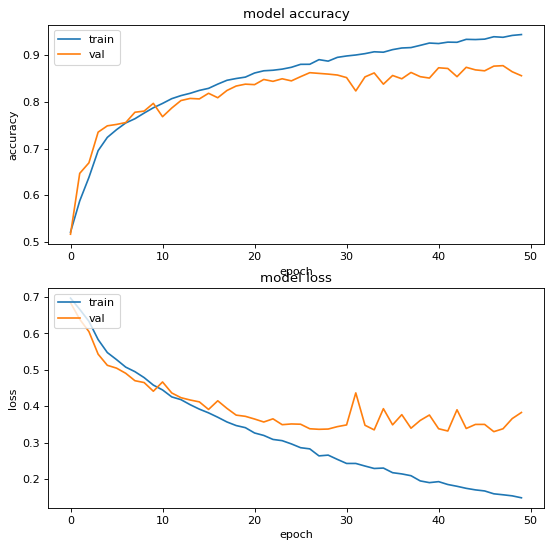

In [ ]:
plot_loss_acc(history3)

ACCURACY ON TEST SET

In [ ]:
test_accuracy=model3.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.8635727167129517


In [ ]:
y_pred=model3.predict(X_test)
for i in range(0,len(y_pred)): y_pred[i]=np.round(y_pred[i])

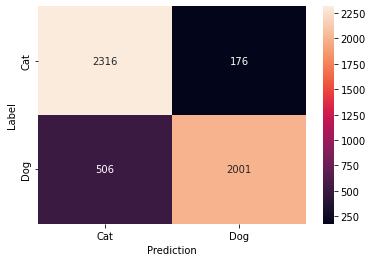

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
labels = ['Cat','Dog']
sns.heatmap(conf_mat,
            xticklabels=labels,
            yticklabels=labels,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## EXPERIMENT 2: Cross Validation

In [ ]:
acc,loss=cross_validation_function(X,y,50,"deep_model")

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


********************ITERATION  1 ***********************
Epoch 1/50
313/313 [==============================] - 6s 17ms/step - loss: 0.6739 - acc: 0.5665
Epoch 2/50
313/313 [==============================] - 5s 17ms/step - loss: 0.6097 - acc: 0.6674
Epoch 3/50
313/313 [==============================] - 5s 17ms/step - loss: 0.5592 - acc: 0.7114
Epoch 4/50
313/313 [==============================] - 5s 17ms/step - loss: 0.5273 - acc: 0.7395
Epoch 5/50
313/313 [==============================] - 5s 17ms/step - loss: 0.5027 - acc: 0.7547
Epoch 6/50
313/313 [==============================] - 5s 17ms/step - loss: 0.4814 - acc: 0.7689
Epoch 7/50
313/313 [==============================] - 5s 17ms/step - loss: 0.4635 - acc: 0.7817
Epoch 8/50
313/313 [==============================] - 5s 17ms/step - loss: 0.4384 - acc: 0.7937
Epoch 9/50
313/313 [==============================] - 5s 17ms/step - loss: 0.4219 - acc: 0.8093
Epoch 10/50
313/313 [==============================] - 5s 16ms/step - loss: 0.4

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


********************ITERATION  2 ***********************
Epoch 1/50
313/313 [==============================] - 6s 17ms/step - loss: 0.6744 - acc: 0.5704
Epoch 2/50
313/313 [==============================] - 5s 17ms/step - loss: 0.5862 - acc: 0.6929
Epoch 3/50
313/313 [==============================] - 5s 17ms/step - loss: 0.5340 - acc: 0.7321
Epoch 4/50
313/313 [==============================] - 5s 17ms/step - loss: 0.5036 - acc: 0.7529
Epoch 5/50
313/313 [==============================] - 5s 17ms/step - loss: 0.4715 - acc: 0.7776
Epoch 6/50
313/313 [==============================] - 5s 17ms/step - loss: 0.4457 - acc: 0.7913
Epoch 7/50
313/313 [==============================] - 5s 17ms/step - loss: 0.4210 - acc: 0.8113
Epoch 8/50
313/313 [==============================] - 5s 17ms/step - loss: 0.4024 - acc: 0.8191
Epoch 9/50
313/313 [==============================] - 5s 17ms/step - loss: 0.3837 - acc: 0.8286
Epoch 10/50
313/313 [==============================] - 5s 17ms/step - loss: 0.3

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


********************ITERATION  3 ***********************
Epoch 1/50
313/313 [==============================] - 6s 17ms/step - loss: 0.6669 - acc: 0.5842
Epoch 2/50
313/313 [==============================] - 5s 17ms/step - loss: 0.5808 - acc: 0.6942
Epoch 3/50
313/313 [==============================] - 5s 17ms/step - loss: 0.5380 - acc: 0.7271
Epoch 4/50
313/313 [==============================] - 5s 17ms/step - loss: 0.5130 - acc: 0.7465
Epoch 5/50
313/313 [==============================] - 5s 17ms/step - loss: 0.4876 - acc: 0.7624
Epoch 6/50
313/313 [==============================] - 5s 16ms/step - loss: 0.4655 - acc: 0.7785
Epoch 7/50
313/313 [==============================] - 5s 16ms/step - loss: 0.4422 - acc: 0.7929
Epoch 8/50
313/313 [==============================] - 5s 17ms/step - loss: 0.4192 - acc: 0.8095
Epoch 9/50
313/313 [==============================] - 5s 17ms/step - loss: 0.4007 - acc: 0.8176
Epoch 10/50
313/313 [==============================] - 5s 17ms/step - loss: 0.3

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


********************ITERATION  4 ***********************
Epoch 1/50
313/313 [==============================] - 6s 17ms/step - loss: 0.6704 - acc: 0.5731
Epoch 2/50
313/313 [==============================] - 5s 17ms/step - loss: 0.5878 - acc: 0.6850
Epoch 3/50
313/313 [==============================] - 5s 17ms/step - loss: 0.5450 - acc: 0.7253
Epoch 4/50
313/313 [==============================] - 5s 17ms/step - loss: 0.5200 - acc: 0.7452
Epoch 5/50
313/313 [==============================] - 5s 17ms/step - loss: 0.4918 - acc: 0.7635
Epoch 6/50
313/313 [==============================] - 5s 17ms/step - loss: 0.4700 - acc: 0.7750
Epoch 7/50
313/313 [==============================] - 5s 17ms/step - loss: 0.4466 - acc: 0.7916
Epoch 8/50
313/313 [==============================] - 5s 17ms/step - loss: 0.4249 - acc: 0.8029
Epoch 9/50
313/313 [==============================] - 5s 17ms/step - loss: 0.4058 - acc: 0.8169
Epoch 10/50
313/313 [==============================] - 5s 17ms/step - loss: 0.3

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


********************ITERATION  5 ***********************
Epoch 1/50
313/313 [==============================] - 6s 17ms/step - loss: 0.6947 - acc: 0.5345
Epoch 2/50
313/313 [==============================] - 5s 17ms/step - loss: 0.6362 - acc: 0.6334
Epoch 3/50
313/313 [==============================] - 5s 16ms/step - loss: 0.5820 - acc: 0.6975
Epoch 4/50
313/313 [==============================] - 5s 17ms/step - loss: 0.5465 - acc: 0.7263
Epoch 5/50
313/313 [==============================] - 5s 17ms/step - loss: 0.5189 - acc: 0.7403
Epoch 6/50
313/313 [==============================] - 5s 17ms/step - loss: 0.4996 - acc: 0.7582
Epoch 7/50
313/313 [==============================] - 5s 17ms/step - loss: 0.4815 - acc: 0.7702
Epoch 8/50
313/313 [==============================] - 5s 17ms/step - loss: 0.4584 - acc: 0.7840
Epoch 9/50
313/313 [==============================] - 5s 17ms/step - loss: 0.4403 - acc: 0.7978
Epoch 10/50
313/313 [==============================] - 5s 17ms/step - loss: 0.4

In [ ]:
print_acc_loss(acc,loss)

The average accuracy is:  88.3 %
The average loss is:  585.0


# 4TH MODEL

Model with some preprocessing layers (for data augmentation)

In [ ]:
gc.collect()

88

In [ ]:
def augm_model():
    model = tf.keras.models.Sequential()
    

    model.add( tf.keras.layers.Rescaling(1./255, input_shape=(80, 80, 3)))
    model.add( tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"))
    model.add( tf.keras.layers.RandomZoom(.5, .2))
    model.add(tf.keras.layers.RandomContrast(factor=0.2))


    model.add( tf.keras.layers.Conv2D(24, 5, activation='relu'))
    model.add( tf.keras.layers.MaxPooling2D(2) )
    
    model.add( tf.keras.layers.Conv2D(48, 5, activation='relu' ))
    model.add( tf.keras.layers.MaxPooling2D(2) )
    
    model.add( tf.keras.layers.Conv2D(96, 5, activation='relu' ))
    model.add( tf.keras.layers.Flatten() )
    
    model.add( tf.keras.layers.Dropout(0.9) )
    model.add( tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
              metrics=['acc'])
    return model

## EXAMPLE ON HOW AN AUGMENTATION LAYER WORKS.

In [ ]:
test_image=X[15]
test_image

array([[[ 99.13438  ,  97.13438  ,  98.13438  ],
        [102.435936 , 101.435936 ,  99.435936 ],
        [ 97.4625   ,  96.4625   ,  92.4625   ],
        ...,
        [ 17.920313 ,  20.609375 ,  25.926563 ],
        [ 12.403126 ,  17.070312 ,  20.154688 ],
        [ 13.829687 ,  18.45625  ,  26.476562 ]],

       [[102.06563  , 100.06563  , 101.06563  ],
        [ 95.782814 ,  94.782814 ,  92.782814 ],
        [ 95.28437  ,  94.28437  ,  90.28437  ],
        ...,
        [ 18.328125 ,  11.640625 ,  18.171875 ],
        [  9.195313 ,  10.298438 ,  14.890626 ],
        [ 38.12969  ,  47.74531  ,  61.001564 ]],

       [[ 98.33594  ,  96.33594  ,  97.33594  ],
        [ 99.55469  ,  98.55469  ,  96.55469  ],
        [ 98.640625 ,  97.640625 ,  93.640625 ],
        ...,
        [ 17.851562 ,   7.3515625,   7.3515625],
        [ 17.109375 ,  11.703125 ,   7.890625 ],
        [ 85.296875 ,   4.90625  ,  17.671875 ]],

       ...,

       [[ 67.88281  ,  77.88281  ,  69.88281  ],
        [ 6

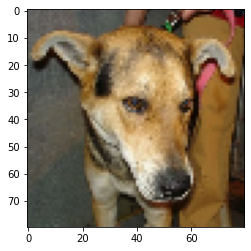

In [ ]:
#1: rescale it:
scale = tf.keras.layers.Rescaling(1./255, input_shape=(80, 80, 3))
scaled_image =scale(test_image, training=True)
#pixel now in [0,1]
plt.imshow(scaled_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


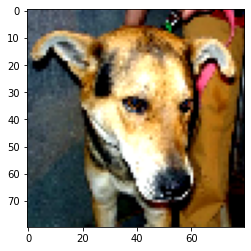

In [ ]:
#2 Applly contrast
random_bright = tf.keras.layers.RandomContrast(factor=1)
output = random_bright(scaled_image, training=True)
plt.imshow(output)

## EXPERIMENT 1: Training with train, test, val split

In [ ]:
model4=augm_model()
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 80, 80, 3)         0         
                                                                 
 random_flip (RandomFlip)    (None, 80, 80, 3)         0         
                                                                 
 random_zoom (RandomZoom)    (None, 80, 80, 3)         0         
                                                                 
 random_contrast (RandomCont  (None, 80, 80, 3)        0         
 rast)                                                           
                                                                 
 conv2d (Conv2D)             (None, 76, 76, 24)        1824      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 38, 38, 24)       0         
 )                                                      

In [ ]:
batch_size=64
n_epochs=300

startTime = time.time()
# fit model
history4 = model4.fit(X_train, 
                      y_train,
                      epochs=n_epochs, 
                      validation_data=(X_valid, y_valid),
                      batch_size=batch_size,
                      verbose=1)
print(time.time()-startTime)

Epoch 1/300
282/282 [==============================] - 18s 20ms/step - loss: 0.6868 - acc: 0.5415 - val_loss: 0.6548 - val_acc: 0.6230
Epoch 2/300
282/282 [==============================] - 5s 18ms/step - loss: 0.6510 - acc: 0.6176 - val_loss: 0.6312 - val_acc: 0.6420
Epoch 3/300
282/282 [==============================] - 5s 18ms/step - loss: 0.6268 - acc: 0.6530 - val_loss: 0.5990 - val_acc: 0.6750
Epoch 4/300
282/282 [==============================] - 5s 18ms/step - loss: 0.6064 - acc: 0.6752 - val_loss: 0.5724 - val_acc: 0.6970
Epoch 5/300
282/282 [==============================] - 5s 18ms/step - loss: 0.5849 - acc: 0.6897 - val_loss: 0.5685 - val_acc: 0.6985
Epoch 6/300
282/282 [==============================] - 5s 18ms/step - loss: 0.5683 - acc: 0.7076 - val_loss: 0.5404 - val_acc: 0.7270
Epoch 7/300
282/282 [==============================] - 5s 18ms/step - loss: 0.5609 - acc: 0.7129 - val_loss: 0.5432 - val_acc: 0.7265
Epoch 8/300
282/282 [==============================] - 5s 18m

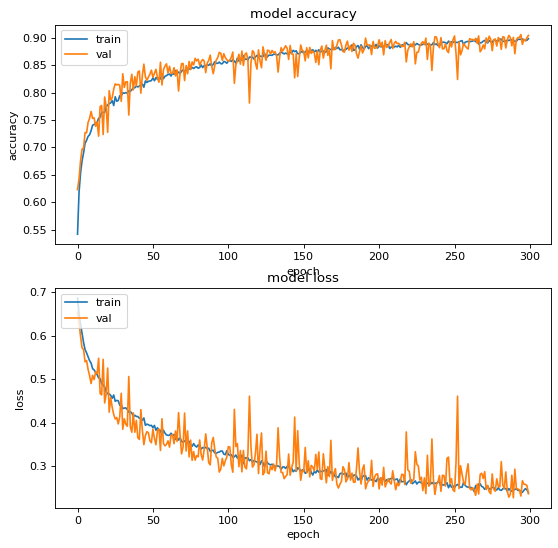

In [ ]:
plot_loss_acc(history4)

If you run the previous two cells with epochs=50 you probably will notice that the model will not overfit. We can also see that the loss is still decreasing and the accuracy is still increasing. So we can try to run with an higher number of epochs (es 300). 

In [ ]:
gc.collect()

2658

ACCURACY ON TEST SET

In [ ]:
test_accuracy=model4.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.8999800086021423


In [ ]:
y_pred=model4.predict(X_test)
for i in range(0,len(y_pred)): y_pred[i]=np.round(y_pred[i])

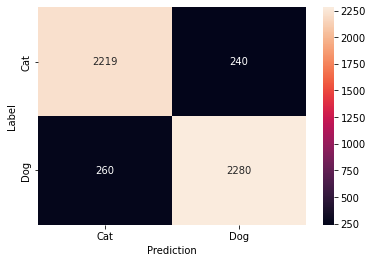

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
labels = ['Cat','Dog']
sns.heatmap(conf_mat,
            xticklabels=labels,
            yticklabels=labels,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## EXPERIMENT 2: Cross Validation

In [ ]:
acc,loss=cross_validation_function(X,y,150,"augm_model")

********************ITERATION  1 ***********************
Epoch 1/150
313/313 [==============================] - 21s 22ms/step - loss: 0.6882 - acc: 0.5351
Epoch 2/150
313/313 [==============================] - 6s 19ms/step - loss: 0.6573 - acc: 0.6039
Epoch 3/150
313/313 [==============================] - 6s 19ms/step - loss: 0.6336 - acc: 0.6388
Epoch 4/150
313/313 [==============================] - 5s 17ms/step - loss: 0.6114 - acc: 0.6662
Epoch 5/150
313/313 [==============================] - 5s 17ms/step - loss: 0.5951 - acc: 0.6776
Epoch 6/150
313/313 [==============================] - 5s 17ms/step - loss: 0.5785 - acc: 0.6967
Epoch 7/150
313/313 [==============================] - 6s 18ms/step - loss: 0.5671 - acc: 0.7045
Epoch 8/150
313/313 [==============================] - 5s 17ms/step - loss: 0.5592 - acc: 0.7158
Epoch 9/150
313/313 [==============================] - 5s 17ms/step - loss: 0.5489 - acc: 0.7218
Epoch 10/150
313/313 [==============================] - 5s 17ms/step 

In [ ]:
print_acc_loss(acc,loss)

The average accuracy is:  87.8 %
The average loss is:  610.0


In [ ]:
gc.collect()

2291

As we saw in the exèeriment 1, using 300 epochs would lead us to a slightly better accuracy (90%).

# 5TH MODEL

This is the very exact model used in the previous section (4TH MODEL) but without the augmentation preprocessing layers. This model is intended to show the importance of them and to show also how the  performance are affected.

In [ ]:
def not_augm_model():
    model = tf.keras.models.Sequential()
    

    model.add( tf.keras.layers.Rescaling(1./255, input_shape=(80, 80, 3)))

    model.add( tf.keras.layers.Conv2D(24, 5, activation='relu'))
    model.add( tf.keras.layers.MaxPooling2D(2) )
    
    model.add( tf.keras.layers.Conv2D(48, 5, activation='relu' ))
    model.add( tf.keras.layers.MaxPooling2D(2) )
    
    model.add( tf.keras.layers.Conv2D(96, 5, activation='relu' ))
    model.add( tf.keras.layers.Flatten() )
    
    model.add( tf.keras.layers.Dropout(0.9) )
    model.add( tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
              metrics=['acc'])
    return model

## EXPERIMENT 1: Training with trin, test, val split

In [ ]:
prova=not_augm_model()
batch_size=64
n_epochs=150

startTime = time.time()
# fit model
history5 = prova.fit(X_train, 
                      y_train,
                      epochs=n_epochs, 
                      validation_data=(X_valid, y_valid),
                      batch_size=batch_size,
                      verbose=1)
print(time.time()-startTime)

Epoch 1/60
282/282 [==============================] - 6s 17ms/step - loss: 0.6828 - acc: 0.5496 - val_loss: 0.6499 - val_acc: 0.6185
Epoch 2/60
282/282 [==============================] - 5s 16ms/step - loss: 0.6382 - acc: 0.6257 - val_loss: 0.6280 - val_acc: 0.6440
Epoch 3/60
282/282 [==============================] - 5s 16ms/step - loss: 0.5950 - acc: 0.6761 - val_loss: 0.5773 - val_acc: 0.7050
Epoch 4/60
282/282 [==============================] - 5s 17ms/step - loss: 0.5552 - acc: 0.7138 - val_loss: 0.5495 - val_acc: 0.7105
Epoch 5/60
282/282 [==============================] - 5s 18ms/step - loss: 0.5190 - acc: 0.7448 - val_loss: 0.5264 - val_acc: 0.7450
Epoch 6/60
282/282 [==============================] - 5s 16ms/step - loss: 0.4893 - acc: 0.7677 - val_loss: 0.4817 - val_acc: 0.7730
Epoch 7/60
282/282 [==============================] - 5s 16ms/step - loss: 0.4676 - acc: 0.7777 - val_loss: 0.4549 - val_acc: 0.7995
Epoch 8/60
282/282 [==============================] - 5s 17ms/step - 

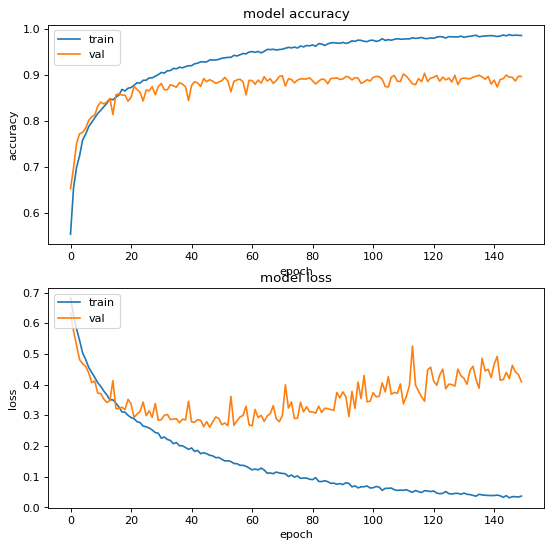

In [ ]:
plot_loss_acc(history5)

ACCURACY ON TEST SET

In [ ]:
test_accuracy=prova.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.9047809839248657


In [ ]:
y_pred=prova.predict(X_test)
for i in range(0,len(y_pred)): y_pred[i]=np.round(y_pred[i])

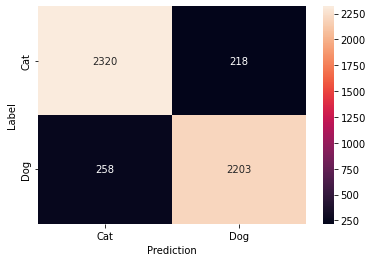

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
labels = ['Cat','Dog']
sns.heatmap(conf_mat,
            xticklabels=labels,
            yticklabels=labels,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## EXPERIMENT 2: Cross Validation

In [ ]:
acc,loss=cross_validation_function(X,y,50,"not_augm_model")

********************ITERATION  1 ***********************
Epoch 1/50
313/313 [==============================] - 31s 20ms/step - loss: 0.6697 - acc: 0.5797
Epoch 2/50
313/313 [==============================] - 6s 18ms/step - loss: 0.6202 - acc: 0.6514
Epoch 3/50
313/313 [==============================] - 6s 20ms/step - loss: 0.5787 - acc: 0.6939
Epoch 4/50
313/313 [==============================] - 5s 16ms/step - loss: 0.5404 - acc: 0.7307
Epoch 5/50
313/313 [==============================] - 5s 16ms/step - loss: 0.5050 - acc: 0.7533
Epoch 6/50
313/313 [==============================] - 5s 16ms/step - loss: 0.4727 - acc: 0.7748
Epoch 7/50
313/313 [==============================] - 5s 16ms/step - loss: 0.4470 - acc: 0.7916
Epoch 8/50
313/313 [==============================] - 5s 17ms/step - loss: 0.4237 - acc: 0.8057
Epoch 9/50
313/313 [==============================] - 5s 17ms/step - loss: 0.4037 - acc: 0.8160
Epoch 10/50
313/313 [==============================] - 5s 17ms/step - loss: 0.

In [ ]:
print_acc_loss(acc,loss)

The average accuracy is:  88.58 %
The average loss is:  571.0


The 5th model overfits but it still is able to mantian an high accuracy on the test set. Model 4th (the model with augmnetation) as we see in the corresponding plot do not overfit but require an higher number of epochs to achive 90% of accuracy on the test set. For time problem we are not able to run the cross validation on it for 300 epochs (300 * 5 seconds per epoch * 5=more than two hours).

I would conclude that model4 is the best. We could try to use higher resolution images (but for RAM problem colab do not allow us) or We could try to use some pre trained model as VGG16 or GoogleNet.